# Tuning the resolution of the fine simulation
In light of the preliminary runs, this notebook will explore how the statistical properties of the flow depend on the spatial resolution. In particular, I will now vary the vertical and horizontal resolutions independently. The properties of interest are:
- Number of convective cells, and
- 99th percentile vertical velocity at $z=1/2$.

I keep the same Rayleigh number ($\mathrm{Ra} = 10^8$) but increase the aspect ratio to 8. Furthermore, I have rewritten the governing equations in terms of the normal temperature anomaly, which is measured relative to a constant value, and rescaled the variables so their magnitudes are closer to unity. The equations now read
$$
\begin{align*}
    \mathrm{Ra}\,\mathrm{Pr}^{-1} \left( \partial_t \vec{u} + \vec{u} \cdot \vec{\nabla} \vec{u} \right)
        &= -\vec{\nabla} \pi + \nabla^2 \vec{u} + \theta \hat{z}, \\
    \mathrm{Ra} \left( \partial_t \theta + \vec{u} \cdot \vec{\nabla} \theta \right)
        &= \nabla^2 \theta, \\
    \vec{\nabla} \cdot \vec{u} &= 0
\end{align*}
$$
with boundary conditions
$$
\begin{align*}
    \vec{u}(z=0) &= \vec{0}, & \qquad \vec{u}(z=1) &= \vec{0}, \\
    \theta(z=0) &= -\frac{1}{2}, & \qquad \theta(z=1) &= +\frac{1}{2}.
\end{align*}
$$

In [4]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import glob
from IPython.display import Video

## New initial conditions
Previously, I was initialising the system with a random, normally distributed temperature perturbation at each grid point. It would have been difficult to keep the initial conditions consistent across runs with different resolutions (because they have different numbers of grid points), and I did not bother, assuming that the steady state statistics would be independent of initial conditions. It appears that this is not the case: even at the same resolution, different realisations of the random initial condition can produce different numbers of convective cells in the steady state. Compare the two runs shown below, which both have 1024 x 128 resolution:

In [2]:
Video('../data/dns_1024_128_longer/dns_1024_128_longer_s1.mp4')

In [3]:
Video('../data/restest_1024_128/restest_1024_128_s1.mp4')

The first run has 5 convective cells, while the second has 4! This indicates that our system exhibits spontaneous symmetry breaking, a property not found in simpler toy models. This means that we have a versatile parametrisation test-bed that exhibits a rich range of behaviour and can be tuned to make parametrisation more or less difficult by initialising it closer or further from the tipping points between convective regimes. For now though, the symmetry breaking is making it difficult to obtain accurate statistics and assess the degree of convergence.

To remedy this, I will impose a deterministic initial condition that favours 4 convective cells (i.e., safely away from the tipping point) and is easily reproduced at different resolutions. It has the functional form
$$
    \theta_0(x,z) = -\frac{1}{2} \operatorname{sgn}\left(z - \frac{1}{2}\right)
        |2z - 1|^{f(x,z)}
$$
where
$$
    f(x,z) = \begin{cases}
        6 - g(x) & z < 1/2 \\
        6 - g(x - 1) & z > 1/2
    \end{cases}
$$
and
$$
    g(x) = \cos(\pi x)
        + \frac{1}{10} \cos\left[\frac{41\pi}{4}\left(x - \frac{1}{4}\right)\right]
$$
At any given $x$, the vertical profile of $\theta_0$ looks like this:

[Text(0.5, 0, '$\\theta_0$'), Text(0, 0.5, '$z$')]

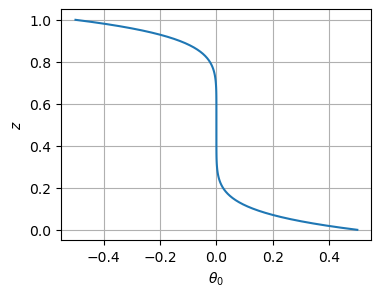

In [8]:
z = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(-0.5*np.sign(z - 0.5)*np.abs(2*z - 1)**6, z)
ax.grid()
ax.set(xlabel='$\\theta_0$', ylabel='$z$')

The variable exponent $f(x,z)$ changes the sharpness of the transitions at the top and bottom, allowing the creation of localised temperature perturbations near the boundaries that favour the formation of updrafts and downdrafts. Below is an animation showing the initial condition in 2D and its subsequent evolution at 768 x 96 resolution:

In [58]:
Video('../data/restest_newinit_768_96/restest_newinit_768_96_s1.mp4')

## Spin-up and simulation time
The next two subsections analyse the same run that is shown above, which has the following parameters:
- Aspect ratio 8
- $\mathrm{Ra} = 10^8$
- $\mathrm{Pr} = 1$
- 768 horizontal modes
- 96 vertical modes
- Time step 26.7
- Simulation length $2 \times 10^6$ time units

### Spin-up time
We are interested in the steady-state 99th percentile velocity, so the initial transients must be discarded. The plot below shows the evolution of the histogram of $|w(z=1/2)|$ over time.

In [55]:
files = glob.glob(
    '../data/restest_newinit_768_96/restest_newinit_768_96_s*.nc')
data = xr.open_mfdataset(files)

In [80]:
w_mid = data.w.interp(z=0.5)
lim = np.abs(w_mid).max()
w_bin_edges = np.linspace(0, lim, 40)
w_bin_centers = (w_bin_edges[:-1] + w_bin_edges[1:])/2

def hist(array):
    return array.groupby_bins(array, w_bin_edges).count().fillna(0)

t_bin_edges = np.arange(0, w_mid.t[-1], 3e3*26.7)
t_bin_centers = (t_bin_edges[:-1] + t_bin_edges[1:])/2
w_mid_grouped = np.abs(w_mid).chunk(dict(t=-1)).groupby_bins('t', t_bin_edges)
w_mid_hist = w_mid_grouped.map(hist)
w_mid_99 = w_mid_grouped.quantile(0.99, dim=['x', 't'])

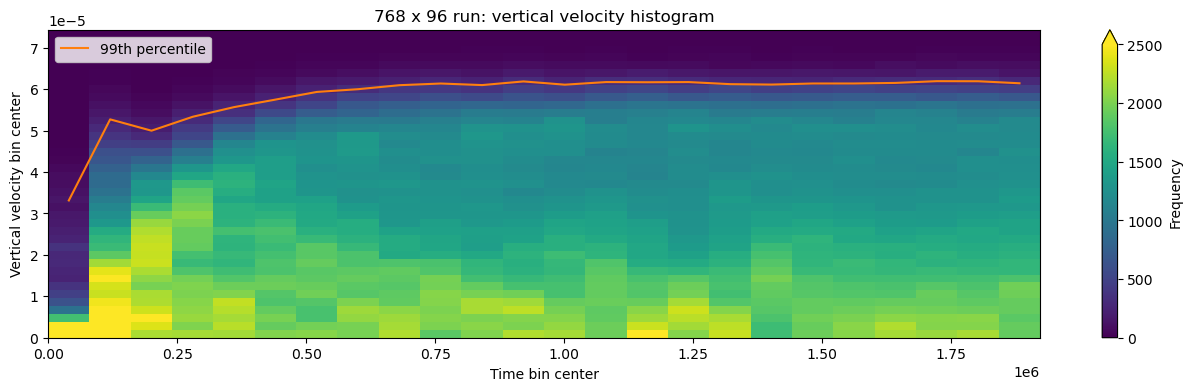

In [82]:
fig, ax = plt.subplots(figsize=(16,4))
mesh = ax.pcolormesh(t_bin_centers, w_bin_centers, w_mid_hist.T, vmax=2.5e3)
fig.colorbar(mesh, ax=ax, label='Frequency', extend='max')
ax.plot(t_bin_centers, w_mid_99, color='tab:orange', label='99th percentile')
ax.set(
    xlabel='Time bin center',
    ylabel='Vertical velocity bin center',
    title='768 x 96 run: vertical velocity histogram'
)
ax.legend(loc='upper left')

It appears that the distribution reaches equilibrium after approximately 10^6 time units. This is confirmed by plotting the percentage deviation of the 99th percentile from its final value:

[Text(0.5, 0, 'Time bin center'),
 Text(0, 0.5, 'Percentage change in 99th percentile')]

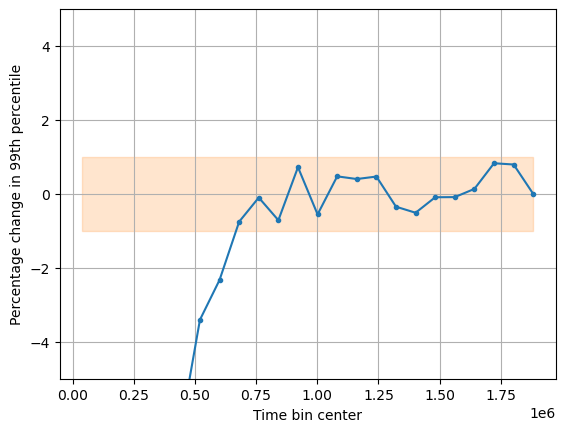

In [83]:
fig, ax = plt.subplots()
ax.fill_between(t_bin_centers, -1, 1, alpha=0.2, color='tab:orange')
ax.plot(t_bin_centers, (w_mid_99/w_mid_99[-1] - 1)*1e2, '.-')
ax.set_ylim(-5, 5)
ax.grid()
ax.set(xlabel='Time bin center', ylabel='Percentage change in 99th percentile')

If the estimates are to be accurate within 1%, then 10^6 time units of spin-up are required.

### Simulation time
The period of simulation after spin-up must also be long enough for the sample quantiles to be close to their true values. Below is a plot of the 99th percentile as a function of the time span over which it is calculated.

In [87]:
t_spinup = 1e6
end_times = w_mid.t[w_mid.t > t_spinup][::10]

def percentile_99(end_time):
    data = w_mid[(w_mid.t >= t_spinup) & (w_mid.t <= end_time)]
    return data.chunk(dict(t=-1)).quantile(0.99)

percentiles = xr.apply_ufunc(percentile_99, end_times, vectorize=True)

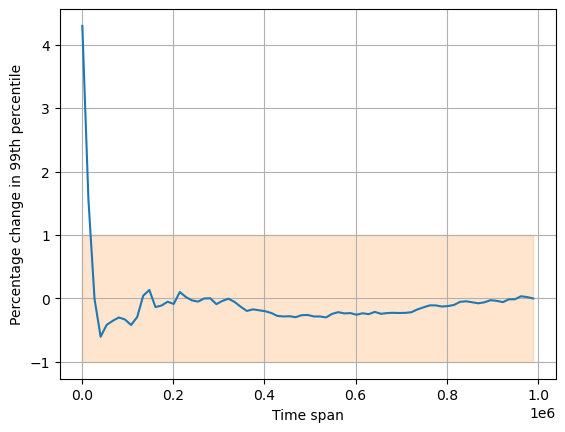

In [88]:
fig, ax = plt.subplots()
ax.plot(end_times - t_spinup, (percentiles/percentiles[-1] - 1)*1e2)
ax.set(xlabel='Time span', ylabel='Percentage change in 99th percentile')
ax.fill_between(end_times - t_spinup, -1, 1, color='tab:orange', alpha=0.2)
ax.grid()

If we again require accuracy within 1%, then the necessary time span is much less than the spin-up time: $10^5$ time units should suffice, but we will use $2\times 10^5$ to be safe.

## Model runs
We are now ready to run the model at each resolution. It would be unrealistic to keep the time step constant, so I will instead scale it in proportion to the spatial resolution by fixing the Courant number. That is, if the subscripts 1 and 2 denote two different runs,
$$
    \Delta t_1 \left( \frac{u_1}{\Delta x_1} + \frac{w_1}{\Delta z_1} \right)
    = \Delta t_2 \left( \frac{u_2}{\Delta x_2} + \frac{w_2}{\Delta z_2} \right).
$$
If we assume that the runs have similar velocities, and that the vertical and horizontal velocity scales are similar, this reduces to
$$
\begin{align*}
    \Delta t_2 &\approx \frac{1/\Delta x_1 + 1/\Delta z_1}{1/\Delta x_2 + 1/\Delta z_2} \\
    &\approx \frac{N_{x1}/\alpha + N_{z1}}{N_{x2}/\alpha + N_{z2}}
\end{align*}
$$
where $\alpha = 8$ is the aspect ratio. The table below shows the $(N_x, N_z)$ pairs that will be tested, and the corresponding time steps (to 3 significant figures).


<style>
    td {
      text-align: center;
    }
</style>

<table>
<tbody>
  <tr>
    <td></td>
    <td></td>
    <td colspan="7">Nx</td>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>128</td>
    <td>192</td>
    <td>256</td>
    <td>384</td>
    <td>512</td>
    <td>768</td>
    <td>1024</td>
  </tr>
  <tr>
    <td rowspan="7">Nz</td>
    <td>16</td>
    <td>160</td>
    <td>-</td>
    <td>107</td>
    <td>-</td>
    <td>-</td>
    <td>-</td>
    <td>-</td>
  </tr>
  <tr>
    <td>24</td>
    <td>-</td>
    <td>107</td>
    <td>-</td>
    <td>71</td>
    <td>-</td>
    <td>-</td>
    <td>-</td>
  </tr>
  <tr>
    <td>32</td>
    <td>107</td>
    <td>-</td>
    <td>80.0</td>
    <td>-</td>
    <td>53.3</td>
    <td>-</td>
    <td>-</td>
  </tr>
  <tr>
    <td>48</td>
    <td>-</td>
    <td>71</td>
    <td>-</td>
    <td>53.3</td>
    <td>-</td>
    <td>35.6</td>
    <td>-</td>
  </tr>
  <tr>
    <td>64</td>
    <td>-</td>
    <td>-</td>
    <td>53.3</td>
    <td>-</td>
    <td>40.0</td>
    <td>-</td>
    <td>26.7</td>
  </tr>
  <tr>
    <td>96</td>
    <td>-</td>
    <td>-</td>
    <td>-</td>
    <td>35.6</td>
    <td>-</td>
    <td>26.7</td>
    <td>-</td>
  </tr>
  <tr>
    <td>128</td>
    <td>-</td>
    <td>-</td>
    <td>-</td>
    <td>-</td>
    <td>26.7</td>
    <td>-</td>
    <td>20.0</td>
  </tr>
</tbody>
</table>

### Number of convective cells
First of all, I check the number of convective cells in each simulation.

In [7]:
def plot_theta(nx, nz, ax):
    files = glob.glob(
        f'../data/restest_newinit_{nx:d}_{nz:d}'
        f'/restest_newinit_{nx:d}_{nz:d}_s*.nc')
    data = xr.open_mfdataset(files)

    ax.pcolormesh(data.x, data.z, data.theta.interp(t=1.1e6).T, cmap='RdBu_r')
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f'{nx:d} x {nz:d}')

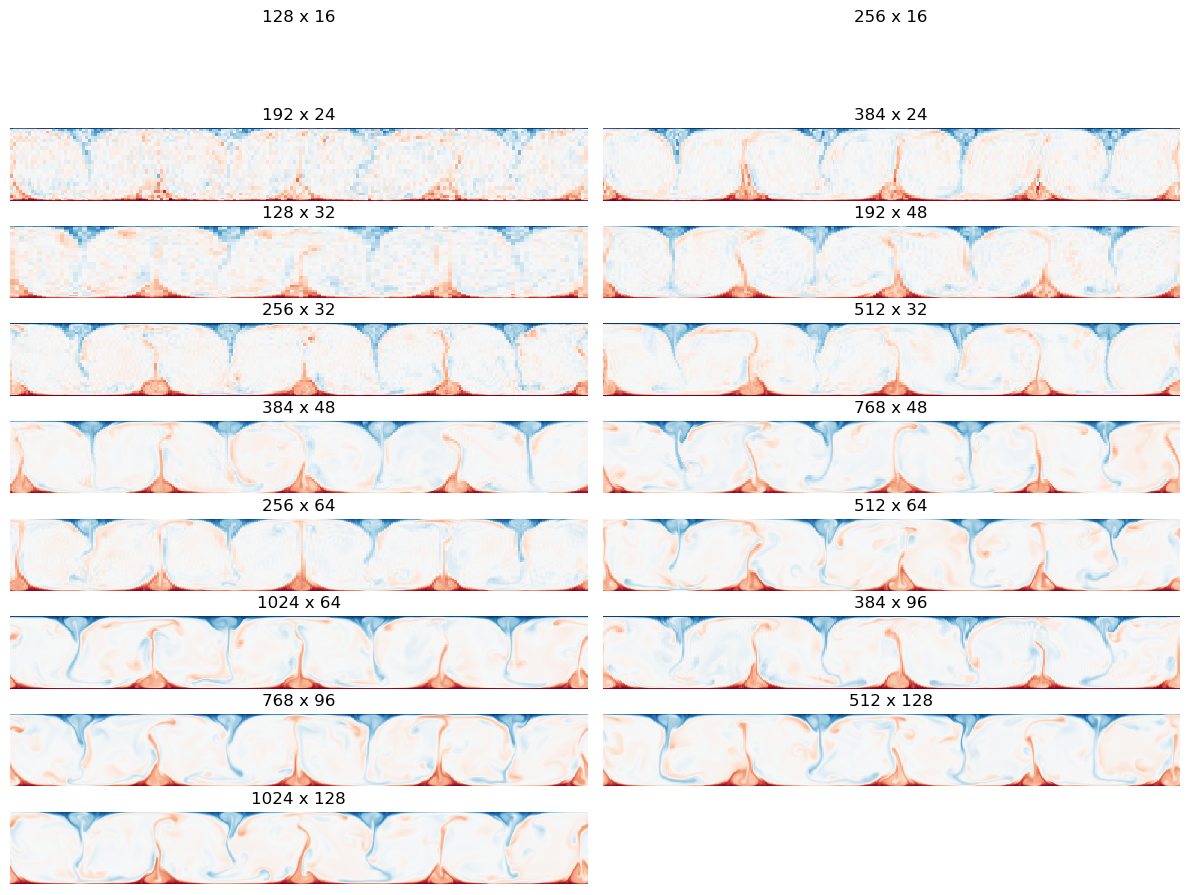

In [26]:
nx = [
    128, 256, 192, 384, 128, 192, 256, 512,
    384, 768, 256, 512, 1024, 384, 768, 512, 1024,
]
nz = [16, 16, 24, 24, 32, 48, 32, 32, 48, 48, 64, 64, 64, 96, 96, 128, 128]
fig, axes = plt.subplots(9, 2, figsize=(12, 9))
for i in range(17):
    plot_theta(nx[i], nz[i], axes.flat[i])
axes[8, 1].axis('off')
fig.tight_layout()

The choice of initial condition has successfully ensured that all runs (except 128x16 and 256x16, which crashed) have 4 convective cells. This allows us to proceed to calculating the 99th percentile velocity.

### 99th percentile velocity
The plot below shows the 99th percentile value of $|w(z=1/2)|$ for $10^6 \leq t \leq 1.2 \times 10^6$ at the different resolutions, expressed as a percentage deviation from the value for the highest resolution run.

In [40]:
def w_99(nx, nz):
    files = glob.glob(
        f'../data/restest_newinit_{nx:d}_{nz:d}'
        f'/restest_newinit_{nx:d}_{nz:d}_s*.nc')
    if len(files) == 0:
        return np.nan
    data = xr.open_mfdataset(files)
    w_sample = data.w[(data.t >= 1e6) & (data.t <= 1.2e6)].interp(z=0.5)
    return np.abs(w_sample).chunk(dict(t=-1)).quantile(0.99)

nx = [128, 192, 256, 384, 512, 768, 1024]
nz = [16, 24, 32, 48, 64, 96, 128]
nx = xr.DataArray(nx, coords=[nx], dims=['nx'])
nz = xr.DataArray(nz, coords=[nz], dims=['nz'])

percentiles = xr.apply_ufunc(w_99, nx, nz, vectorize=True)

/srv/ccrc/AtmSS/z5310829/miniconda3/envs/hons/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,
/srv/ccrc/AtmSS/z5310829/miniconda3/envs/hons/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1556: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


[Text(0.5, 0, '$N_x$'), Text(0, 0.5, '$N_z$')]

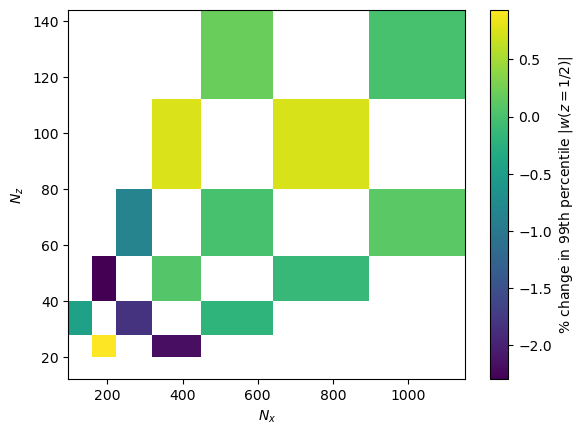

In [41]:
fig, ax = plt.subplots()
mesh = ax.pcolormesh(
    percentiles.nx, percentiles.nz,
    (percentiles.T/percentiles.sel(nx=1024, nz=128) - 1)*1e2
)
fig.colorbar(
    mesh, ax=ax, label='% change in 99th percentile $|w(z=1/2)|$')
ax.set(xlabel='$N_x$', ylabel='$N_z$')

All the runs except a few of the coarsest ones have values within 1% of the highest-resolution run, suggesting that the higher-resolution runs are sufficiently converged to produce accurate velocity statistics.